# EDA: Registre d'explotacions ramaderes

In [1]:
# Carregar paquets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import unidecode
import folium
import re

## Informació del *dataset*

El *dataset* escollit és el **Registre d'explotacions ramaderes de Catalunya**, que es pot trobar a [Dades Obertes de Catalunya](https://analisi.transparenciacatalunya.cat/Medi-Rural-Pesca/Registre-d-explotacions-ramaderes/7bpt-5azk). Aquest *dataset* conté informació sobre les explotacions ramaderes de Catalunya, amb dades com la seva ubicació, el tipus d'explotació, el nombre d'animals que hi ha, etc. Dintre de cadascuna de les seccions, les explotacions es classifiquen en diferents subseccions en funció de la finalitat productiva.

Les dades les proporciona el **Departament d'Acció Climàtica, Alimentació i Agenda Rural**. Aquest s'encarrega d'actualitzar les dades anualment. L'última actualització és del 8 de novembre del 2023, per tant, les dades són ben actuals.

El joc de dades conté més de 26.000 registres i 49 variables. Cada fila és una explotació ramadera i les columnes que conté mostren informació identificativa de les explotacions i característiques d'aquestes. Les variables són de tipus numèric, de text i de data.

Totes les dades que es mostren són públiques. De totes maneres, hi ha informació sobre empreses privades i particulars, per tant, s'ha de tenir cura amb la privacitat de les dades.

A continuació carreguem les dades, en visualitzem l'estructura i mostrem les primeres files:

In [2]:
# Load dataset
df = pd.read_csv("../data/raw/Registre_d_explotacions_ramaderes.csv")

In [3]:
# Convert postal code to object
df["Codi postal explotació"] = df["Codi postal explotació"].astype("object")

# Convert date columns to datetime
df["Data canvi estat explotació"] = pd.to_datetime(df["Data canvi estat explotació"])
df["Data canvi estat subexplotació"] = pd.to_datetime(
    df["Data canvi estat subexplotació"]
)
df["Data classificació zootècnica"] = pd.to_datetime(
    df["Data classificació zootècnica"]
)
df["Data actualització capacitat"] = pd.to_datetime(
    df["Data actualització capacitat"], format="mixed"
)

# See the structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25998 entries, 0 to 25997
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Marca oficial                   25998 non-null  object        
 1   Codi REGA                       25998 non-null  object        
 2   Estat explotació                25998 non-null  object        
 3   Data canvi estat explotació     25998 non-null  datetime64[ns]
 4   Nom explotació                  25998 non-null  object        
 5   Adreça explotació               25998 non-null  object        
 6   Codi postal explotació          25998 non-null  object        
 7   Servei territorial explotació   25998 non-null  object        
 8   Província explotació            25998 non-null  object        
 9   Comarca explotació              25998 non-null  object        
 10  Municipi explotació             25998 non-null  object        
 11  CO

C:\Users\guill\AppData\Local\Temp\ipykernel_5748\666995636.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Data canvi estat explotació"] = pd.to_datetime(df["Data canvi estat explotació"])
C:\Users\guill\AppData\Local\Temp\ipykernel_5748\666995636.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Data classificació zootècnica"] = pd.to_datetime(


In [4]:
# See the first rows of the dataset
df.head()

,Marca oficial,Codi REGA,Estat explotació,Data canvi estat explotació,Nom explotació,Adreça explotació,Codi postal explotació,Servei territorial explotació,Província explotació,Comarca explotació,...,Capacitat transició,Capacitat estants,Capacitat transhumants,Capacitat AN>6M no repr,Capacitat ous,Cap núm. total animals,Total Cap ponedores,Total URM,Total Nitrogen,Data actualització capacitat
0,0010AA,ES250010030750,Activa,1997-01-21,CASA JULIU - JORDI GASA,MASIA JULIU,25651,Alt Pirineu,Lleida,Pallars Jussà,...,0,0,0,0,0,0,0,56,7515,2021-04-10
1,0010AA,ES250010030750,Activa,1997-01-21,CASA JULIU - JORDI GASA,MASIA JULIU,25651,Alt Pirineu,Lleida,Pallars Jussà,...,0,0,0,0,0,0,0,29088,17574,2023-07-21
2,0010AA,ES250010030750,Activa,1997-01-21,CASA JULIU - JORDI GASA,MASIA JULIU,25651,Alt Pirineu,Lleida,Pallars Jussà,...,0,0,0,0,0,0,0,4,2552,2014-11-21
3,0010AA,ES250010030750,Activa,1997-01-21,CASA JULIU - JORDI GASA,MASIA JULIU,25651,Alt Pirineu,Lleida,Pallars Jussà,...,0,0,0,4,0,0,0,4,2552,2014-11-21
4,0010AB,ES250010031100,Activa,1997-04-21,CASA GONELLA,BOIXOLS,25651,Alt Pirineu,Lleida,Pallars Jussà,...,475,0,0,0,0,0,0,19702,1187525,2021-04-10


## Preparació de les dades

En aquest apartat examinarem el dataset per tal d'esbrinar si el conjunt de dades conté valors perduts, valors extrems, etc. Estudiarem si cal homogeneïtzar les dades categòriques i si caldrà extreure característiques.

### Tractament dels valors perduts

In [5]:
# Detectar els valors perduts en cada columna
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100

missing_values_percentage.sort_values(ascending=False)

Codi zootècnic                    99.857681
Forma de cria                     94.326487
Integradora                       76.748211
Capacitat productiva              74.694207
Nom ADS                           55.608124
Subespècie                        48.515270
LATITUD explotació                33.675667
LONGITUD explotació               33.675667
Data classificació zootècnica     25.898146
Classificació zootècnica          25.563505
Petita capacitat                   1.715517
Data actualització capacitat       1.384722
Criteri de sostenibilitat          1.330872
Sistema productiu                  1.303946
Autoconsum                         1.303946
COOR Y explotació                  0.011539
COOR X explotació                  0.011539
Capacitat femelles                 0.000000
Capacitat cria                     0.000000
Capacitat reposició                0.000000
Capacitat engreix                  0.000000
Capacitat recria                   0.000000
Capacitat transició             

L'anàlisi de les dades mancants del dataset "Registre d'explotacions ramaderes de Catalunya" revela els següents punts:

- Valors Perduts: Algunes columnes tenen un nombre significatiu de valors mancants. Per exemple:
    - ``Codi zootècnic`` té gairebé tots els valors mancants (99.86%).
    - ``Forma de cria`` també té una gran quantitat de valors mancants (94.33%).
    - ``Integradora`` i ``Capacitat productiva`` tenen un 76.75% i un 74.69% de valors mancants, respectivament.
    - ``Subespècie`` té un 48.52% de valors mancants.
    - ``LATITUD explotació`` i ``LONGITUD explotació`` tenen aproximadament un 33.68% de valors mancants cadascuna.

- Columnes Complertes: Diverses columnes com ``Marca oficial``, ``Codi REGA``, ``Tipus explotació``, ``Espècie``, etc., no tenen cap valor mancant.

Tant ``Codi zootècnic`` com ``Forma de cria`` tenen un nombre significatiu de valors mancants.  Això és problemàtic, però abans d'eliminar-les, estudiem si estem davant de valors perduts o si realment no hi ha informació disponible. Per exemple, si una explotació no té cap animal, no tindrà cap valor per a ``Codi zootècnic``. Per tant, no es tracta d'un valor perdut, sinó que no hi ha informació disponible. Això també passa amb ``Forma de cria``. Si una explotació no cria animals, no tindrà cap valor per aquesta columna. Per tant, no es tracta d'un valor perdut, sinó que no hi ha informació disponible.

In [6]:
df["Codi zootècnic"].unique()

array([nan, 'ES09RS11P', 'ES09RS18P', 'ES09ET02A', 'ES09RS12P',
       'ES09RS28P', 'ES09RS20P', 'ES09RS32P', 'ES09RS03E', 'ES09RS05P',
       'ES09RS22P', 'ES09RS29P', 'ES09RS19P', 'ES09RS26P', 'ES09059',
       'ES09RS09P', 'ES09RS34P', 'ES09RS35P', 'ES09RS17P', 'ES09RS06P',
       'ES09RS15P', 'ES09RS13P', 'ES09RS02P', 'ES09RS31P', 'ES09ET01E',
       'ES09RS24P', 'ES09RS16P', 'ES09RS27P', 'ES09RS03P', 'ES09RS23P',
       'ES09RS30P', 'ES09RS21P', 'ES09RS37P', 'ES09RS33P', 'ES09060'],
      dtype=object)

El ``Codi zootècnic`` és un identificador per a un centre o equip autoritzat, dedicat a la recollida, emmagatzematge o distribució de material genètic. Aquesta informació no és rellevant per a l'anàlisi que es vol fer, per tant, es pot eliminar la columna.

In [7]:
# Suprimir la columna 'Codi zootècnic'
df = df.drop(columns=["Codi zootècnic"])

In [8]:
df["Forma de cria"].unique()

array([nan, 'Galliner en interior', 'Ecològica', "A l'aire lliure",
       'A terra', 'En gàbia', 'Extensiu en interior', 'Ecològic',
       'Camper tradicional', 'Camper', 'Camper criat en total llibertat'],
      dtype=object)

La columnna ``Forma de cria`` és una classificació atorgada segons la forma de cria de les aus de corral amb orientació productiva producció d'ous de consum (producció ecològica, en camp, a terra o en gàbies) o amb orientació productiva producció per carn (etiquetatge facultatiu).

És evident, que una explotació no tindrà aquest camp si no es dedica a la cria d'aus de corral. Per tant, és normal que no hi hagi informació disponible per molts registres. De moment, no eliminarem la columna, però més endavant, si no és rellevant per a l'anàlisi, la podem eliminar.

La columna ``Integradora`` és l'empresa amb la qual l'explotació ramadera té una relació contractual. Aquesta informació no és rellevant per a l'anàlisi que es vol fer, per tant, es pot eliminar la columna.

In [9]:
# Suprimir la columna 'Integradora'
df = df.drop(columns=["Integradora"])

La columma ``Capacitat productiva`` és la classificació establerta per l'espècie porcina i la família apícola. En les explotacions porcines hi ha 4 grups (explotació de petita capacitat, grup I, grup II, grup III). En el cas de les explotacions apícoles es diferencien 2 grups d'explotacions: les professionals i les no professionals.

Aquesta informació ens pot ser útil més endavant, així que no eliminarem la columna.

La columna ``Nom ADS`` també té molts valors perduts i la seva informació només és útil a nivell burocràtic. Per tant, es pot eliminar la columna.

In [10]:
# Suprimir la columna 'Nom ADS'
df = df.drop(columns=["Nom ADS"])

La resta de variables les deixem tal i com estan.

### Indentificació de les dades categòriques

Volem veure quines columnes són categòriques. Seleccionem les variables que tenen tipus `object`. I un cop tenim la llista, veiem quines són categòriques i quines no.

In [11]:
# Seleccionar les variables categòriques
# Identificar les columnes categòriques del dataframe 'df'
categorical_columns = df.select_dtypes(include=["object"]).columns
categorical_columns.tolist()

['Marca oficial',
 'Codi REGA',
 'Estat explotació',
 'Nom explotació',
 'Adreça explotació',
 'Codi postal explotació',
 'Servei territorial explotació',
 'Província explotació',
 'Comarca explotació',
 'Municipi explotació',
 'LATITUD explotació',
 'LONGITUD explotació',
 'Tipus explotació',
 'Espècie',
 'Subespècie',
 'Tipus subexplotació',
 'Estat subexplotació',
 'Classificació zootècnica',
 'Forma de cria',
 'Autoconsum',
 'Sistema productiu',
 'Criteri de sostenibilitat',
 'Petita capacitat',
 'Capacitat productiva']

D'aquesta llista de variables, totes es poden considerar categòriques excepte:
- ``LATITUD explotació`` i ``LONGITUD explotació``: Són volors numèric (coordenades), encara que per les seves característiques ens interessa més guardar-los com a text o ``object``.
- ``Marca oficial`` i ``Codi REGA``: Tot i que són text, aquestes columnes podrien actuar com a identificadors únics per a cada explotació. Depenent de l'anàlisi, podrien no ser tractades com a variables categòriques típiques, ja que podrien no aportar informació útil en models predictius o en comparacions estadístiques.
- ``Nom explotació`` i ``Adreça explotació``: Són texts que identifiquen l'explotació. Podrien actuar com a identificador únic per a cada explotació. Depenent de l'anàlisi, podria no ser tractada com a variable categòrica típica, ja que podria no aportar informació útil en models predictius o en comparacions estadístiques.

Per tant, les suprimim de la llista de variables categòriques:

In [12]:
# Eliminar les columnes especificades de la llista de columnes categòriques
categorical_columns = categorical_columns.drop(
    [
        "LATITUD explotació",
        "LONGITUD explotació",
        "Marca oficial",
        "Codi REGA",
        "Nom explotació",
        "Adreça explotació",
    ]
)
categorical_columns.tolist()

['Estat explotació',
 'Codi postal explotació',
 'Servei territorial explotació',
 'Província explotació',
 'Comarca explotació',
 'Municipi explotació',
 'Tipus explotació',
 'Espècie',
 'Subespècie',
 'Tipus subexplotació',
 'Estat subexplotació',
 'Classificació zootècnica',
 'Forma de cria',
 'Autoconsum',
 'Sistema productiu',
 'Criteri de sostenibilitat',
 'Petita capacitat',
 'Capacitat productiva']

Canviem a tipus `category` les variables categòriques:

In [13]:
# Convertir les columnes categòriques identificades a tipus 'category'
for col in categorical_columns:
    df[col] = df[col].astype("category")

# Verificar els tipus de dades actualitzats per aquestes columnes
df.dtypes

Marca oficial                             object
Codi REGA                                 object
Estat explotació                        category
Data canvi estat explotació       datetime64[ns]
Nom explotació                            object
Adreça explotació                         object
Codi postal explotació                  category
Servei territorial explotació           category
Província explotació                    category
Comarca explotació                      category
Municipi explotació                     category
COOR X explotació                        float64
COOR Y explotació                        float64
LATITUD explotació                        object
LONGITUD explotació                       object
Tipus explotació                        category
Espècie                                 category
Subespècie                              category
Tipus subexplotació                     category
Estat subexplotació                     category
Data canvi estat sub

## Visualitzar les dades

### Distribució de les variables categòriques

Visualitzem com es distribueixen les variables categòriques:

C:\Users\guill\AppData\Local\Temp\ipykernel_5748\2606864777.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
C:\Users\guill\AppData\Local\Temp\ipykernel_5748\2606864777.py:21: UserWarning: 
The palette list has fewer values (1) than needed (914) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


C:\Users\guill\AppData\Local\Temp\ipykernel_5748\2606864777.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
C:\Users\guill\AppData\Local\Temp\ipykernel_5748\2606864777.py:21: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
C:\Users\guill\AppData\Local\Temp\ipykernel_5748\2606864777.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
C:\Users\guill\AppData\Local\Temp\ipykernel_5748\2606864777.py:21: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
C:\Users\guill\AppData\Local\Temp\ipykernel_5748\2606864777.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i

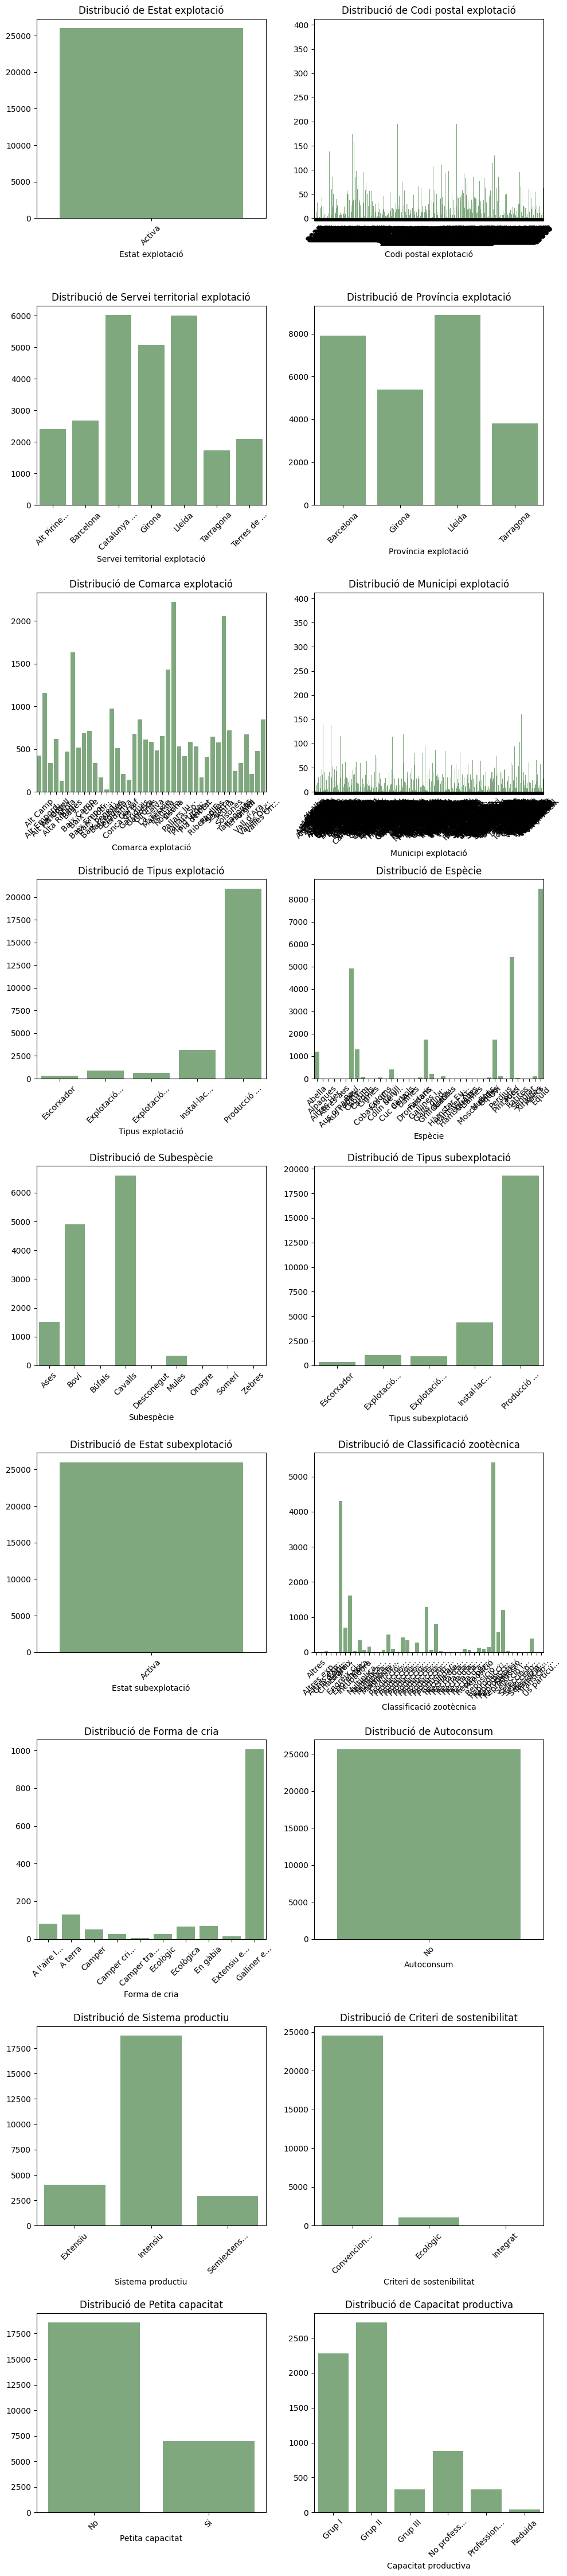

In [14]:
# Crear una llista de colors on els valors més alts tinguin un color més fosc
colors = ["#78af78"]

# Calcular el nombre de columnes i files per al grid
num_vars = len(categorical_columns)
cols = 2  # Número de columnes en el grid
rows = math.ceil(num_vars / cols)

# Crear una figura amb subgràfics en forma de grid
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 5 * rows))

for i, col in enumerate(categorical_columns):
    row = i // cols
    col_index = i % cols
    ax = axes[row, col_index]

    # Calcular la freqüència de les categories
    data = df[col].value_counts()

    # Crear un barplot amb colors personalitzats per a cada barra
    sns.barplot(
        x=data.index, y=data.values, hue=data.index, palette=colors, ax=ax, legend=False
    )
    ax.set_title(f"Distribució de {col}")

    # Truncar les etiquetes llargues i afegir ellipsis
    ax.set_xticklabels(
        [
            text.get_text()[:10] + "..."
            if len(text.get_text()) > 10
            else text.get_text()
            for text in ax.get_xticklabels()
        ]
    )

    ax.tick_params(axis="x", rotation=45)

    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

El primer que sorpren veient els gràfics és que hi ha variables que només tenen una categoria. Aquestes són:
- ``Estat explotació``.
- ``Estat subexplotació``.
- ``Autoconsumm``.

Fem una comprovació ràpida de les dades per veure si és correcte que només tinguin una categoria:

In [15]:
df["Estat explotació"].unique()

['Activa']
Categories (1, object): ['Activa']

In [16]:
df["Estat subexplotació"].unique()

['Activa']
Categories (1, object): ['Activa']

In [17]:
df["Autoconsum"].unique()

['No', NaN]
Categories (1, object): ['No']

Efectivament, aquestes variables només contenen una categoria. Per tant, no aporten cap informació i les podem eliminar.

In [18]:
# Llista de columnes a eliminar
columns_to_drop = ["Estat explotació", "Estat subexplotació", "Autoconsum"]

# Eliminar les columnes especificades
df = df.drop(columns_to_drop, axis=1)

La distribució de la resta de variables categòriques no representa cap problema, així que seguim endavant.

### Distribució de les variables numèriques	

Ara volem fer el mateix amb les variables numèriques. Visualitzem com es distribueixen:

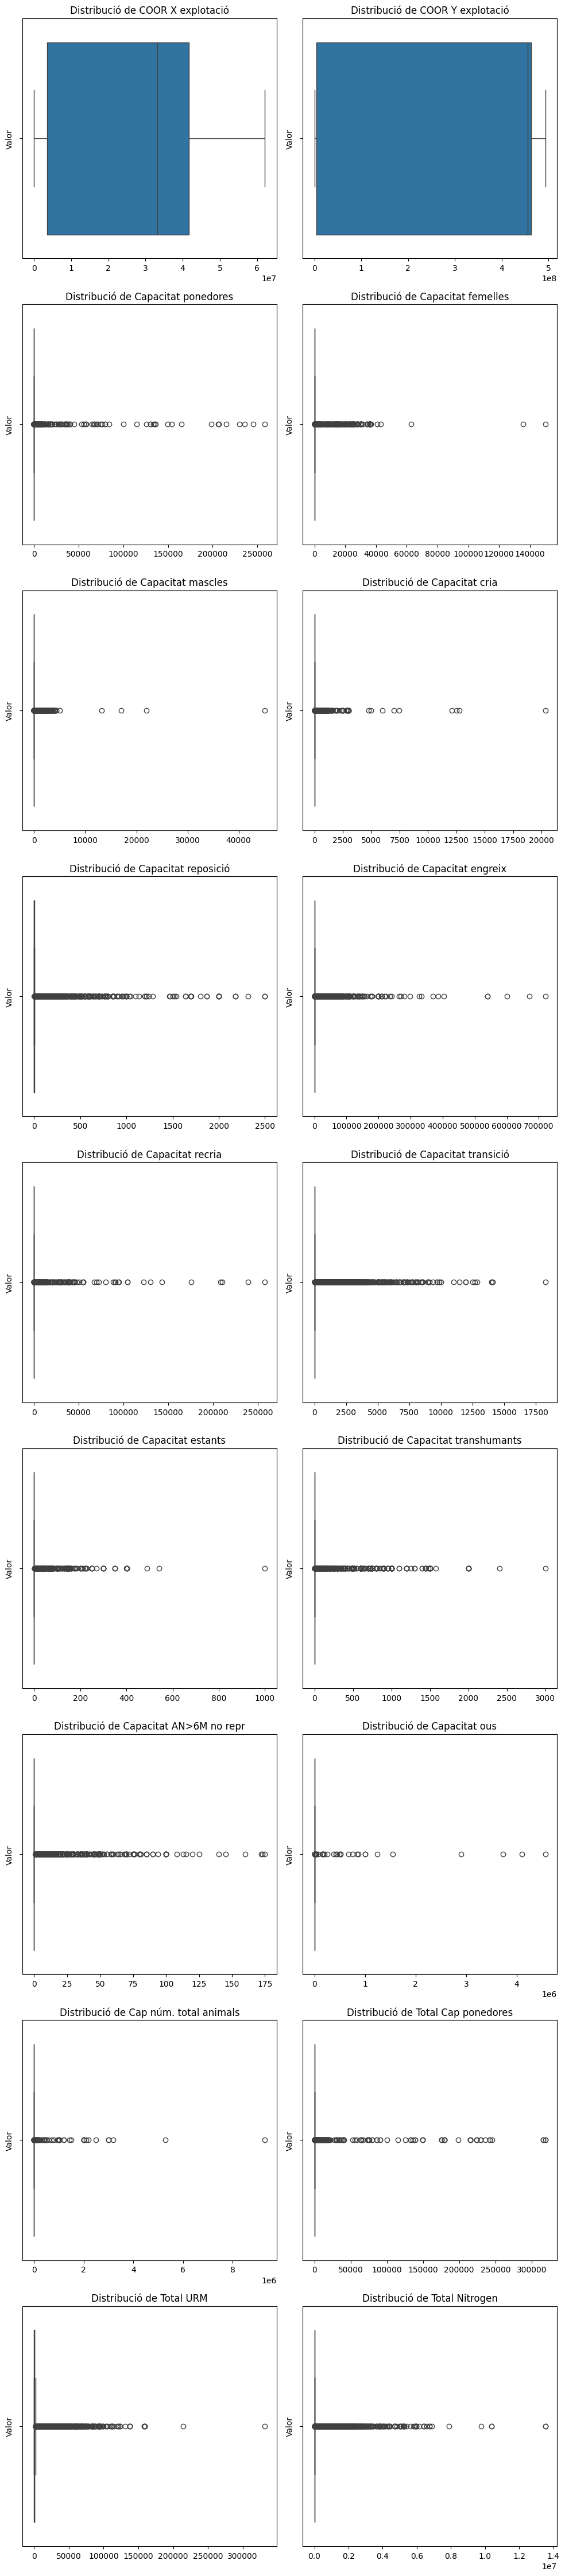

In [19]:
# Seleccionar només les columnes numèriques
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

# Calcular el nombre de files que necessitarem per al grid (2 columnes per fila)
num_vars = len(numeric_columns)
cols = 2
rows = math.ceil(num_vars / cols)

# Crear una figura amb subgràfics
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 5 * rows))

# Iterar sobre les columnes numèriques i crear un box plot per a cada una
for i, col in enumerate(numeric_columns):
    row = i // cols
    col_index = i % cols
    ax = axes[row, col_index]

    sns.boxplot(x=df[col], ax=ax)  # Crear un box plot
    ax.set_title(f"Distribució de {col}")
    ax.set_xlabel("")
    ax.set_ylabel("Valor")

# Amagar els axes sobrants si el nombre de variables no omple l'última fila
if num_vars % cols != 0:
    for j in range(num_vars, rows * cols):
        axes.flat[j].set_visible(False)

plt.tight_layout()
plt.show()

Totes les variables numèriques, excepte les coordenades, tenen valors extrems significatius. Això és normal, ja que hi ha explotacions de diferents mides. Per tant, no eliminarem cap valor.

In [20]:
def dms2dd(s):
    if s == "nan":
        return float("NaN")
    
    # Trobar els números (incloent decimals i signes) dins de la cadena de coordenades
    numbers = re.findall(r"-?\d+\.\d+|-?\d+", s)
    numbers = [float(num) for num in numbers]

    # Convertir a format decimal
    if len(numbers) == 3:  # DMS a DD
        dd = numbers[0] + numbers[1] / 60 + numbers[2] / 3600
    elif len(numbers) == 2:  # DM a DD
        dd = numbers[0] + numbers[1] / 60
    else:  # Ja en format DD
        dd = numbers[0]

    return dd


# Convertir les coordenades DMS a decimal
df["LATITUD"] = (
    df["LATITUD explotació"].astype("str").apply(dms2dd)
)
df["LONGITUD"] = (
    df["LONGITUD explotació"].astype("str").apply(dms2dd)
)

# Eliminar les files on les coordenades són NaN
df_clean = df.dropna(subset=["LATITUD", "LONGITUD"])

# Crear un mapa base
mapa = folium.Map(
    location=[
        df_clean["LATITUD"].mean(),
        df_clean["LONGITUD"].mean(),
    ],
    zoom_start=8,
)

# Afegir punts al mapa
for idx, row in df_clean.iterrows():
    folium.Marker([row["LATITUD"], row["LONGITUD"]]).add_to(mapa)

# Mostrar el mapa
mapa.save("../data/processed/mapa.html")

### Correlació entre les variables

Per detectar associacions entre variables numèriques, podem fer servir la matriu de correlació. Aquesta matriu ens mostra la correlació entre totes les variables numèriques. Així, podem veure si hi ha variables que estan correlacionades i, per tant, podrien ser redundants.

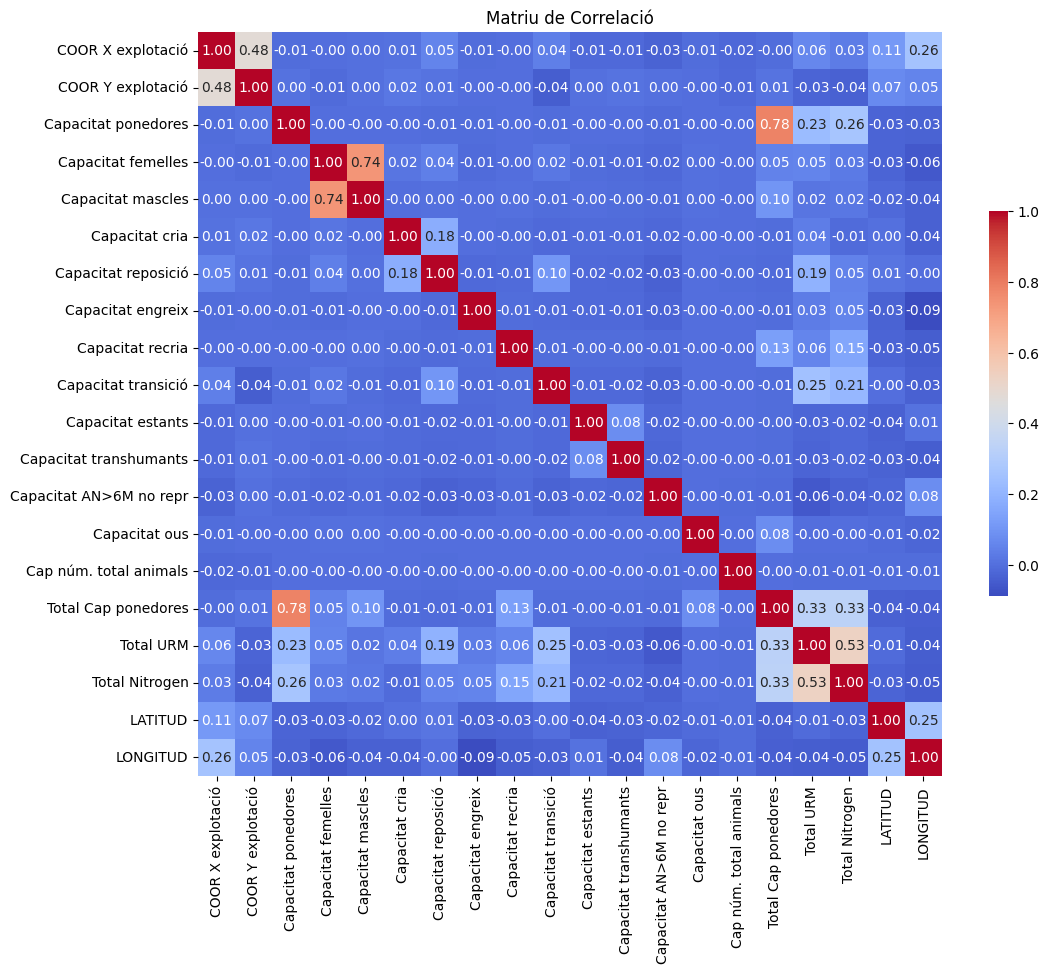

In [21]:
# Seleccionar només les columnes numèriques
numeric_df = df.select_dtypes(include=["number"])

# Calcula la matriu de correlació
correlation_matrix = numeric_df.corr()

# Crea un mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.5},
)
plt.title("Matriu de Correlació")
plt.show()

Les variables que estan significativament correlacionades són:
- ``Capacitat mascles`` i ``Capacitat femelles``.
- ``Total Cap ponedores`` i ``Capacitat ponedores``.

També podem veure que les variables ``Total URM`` i ``Total Nitrogen`` tenen un cert grau de correlació.

La resta de variables no estan correlacionades.

## Canviar noms de columnes

Els noms de les columnes contenen majúscules, espais i accents, això pot ser problemàtic en alguns sistemes d'anàlisis de dades. Per tant, canviem els noms de les columnes per eliminar els espais i els accents.

In [22]:
# Netejar els noms de les columnes
def clean_column_names(column_name):
    # Eliminar els accents dels caràcters
    column_name = unidecode.unidecode(column_name)
    # Reemplaçar els espais amb guions baixos i eliminar caràcters especials
    column_name = (
        column_name.replace(" ", "_")
        .replace(".", "")
        .replace("-", "_")
        .replace(">", "_")
    )
    # Assegurar que el nom de la columna està en minúscules
    column_name = column_name.lower()
    return column_name

# Aplicar la funció de neteja a cada nom de columna
df.columns = [clean_column_names(col) for col in df.columns]

# Comprovar els nous noms de les columnes
print(df.columns)

Index(['marca_oficial', 'codi_rega', 'data_canvi_estat_explotacio',
       'nom_explotacio', 'adreca_explotacio', 'codi_postal_explotacio',
       'servei_territorial_explotacio', 'provincia_explotacio',
       'comarca_explotacio', 'municipi_explotacio', 'coor_x_explotacio',
       'coor_y_explotacio', 'latitud_explotacio', 'longitud_explotacio',
       'tipus_explotacio', 'especie', 'subespecie', 'tipus_subexplotacio',
       'data_canvi_estat_subexplotacio', 'classificacio_zootecnica',
       'data_classificacio_zootecnica', 'forma_de_cria', 'sistema_productiu',
       'criteri_de_sostenibilitat', 'petita_capacitat', 'capacitat_productiva',
       'capacitat_ponedores', 'capacitat_femelles', 'capacitat_mascles',
       'capacitat_cria', 'capacitat_reposicio', 'capacitat_engreix',
       'capacitat_recria', 'capacitat_transicio', 'capacitat_estants',
       'capacitat_transhumants', 'capacitat_an_6m_no_repr', 'capacitat_ous',
       'cap_num_total_animals', 'total_cap_ponedores', 'to

Ara ja tenim les dades preparades per a l'anàlisi.

## Guardar les dades

Guardem les dades en un nou fitxer per a poder-les utilitzar en altres *notebooks*:

In [23]:
# Guardar les dades com a CSV
df.to_csv("../data/processed/explotacions_ramaderes.csv", index_label="id")